# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_mtsc_loader
# from optim import Mytrainer
# from optim.loss import loss_function,init_center
# from datasets import dataloader_pyg as dataloader
# from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [11]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--kfold", type=int, default=None,
        help="K-fold cross validation")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'



## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [6]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [7]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]

# Dataset Loading

### Anomaly Ratio Check

In [47]:
for target_sid in ['1210005301', '1030001902', '1220005401', '1210003000', '1130052300']:
    args.dataset = '{}_mprofile'.format(target_sid)
    print(args.dataset)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)

    y_all = []
    for data in train_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    train_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1])

    y_all = []
    for data in val_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    if len(y_all[1]) == 1:
        val_ratio = 0
    else:
        val_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1])
    
    y_all = []
    for data in test_loader:
        y_all.append(data.y)
    y_all = torch.concat(y_all).unique(return_counts=True)
    if len(y_all[1]) == 1:
        test_ratio = 0
    else:
        test_ratio = y_all[1][1] / y_all[1].sum()
    print(y_all[1])

    print(train_ratio, val_ratio, test_ratio)



1210005301_mprofile
train dataset


100%|██████████| 7485/7485 [00:01<00:00, 4004.44it/s]


val dataset


100%|██████████| 2269/2269 [00:00<00:00, 4334.66it/s]


test dataset


100%|██████████| 2051/2051 [00:00<00:00, 2472.27it/s]


tensor([7441,   44])
tensor([2171,   98])
tensor([1924,  127])
tensor(0.0059) tensor(0.0432) tensor(0.0619)
1030001902_mprofile
train dataset


100%|██████████| 6099/6099 [00:01<00:00, 4586.69it/s]


val dataset


100%|██████████| 1480/1480 [00:00<00:00, 4880.34it/s]


test dataset


100%|██████████| 1749/1749 [00:00<00:00, 4722.59it/s]


tensor([6014,   85])
tensor([1362,  118])
tensor([1606,  143])
tensor(0.0139) tensor(0.0797) tensor(0.0818)
1220005401_mprofile
train dataset


100%|██████████| 10560/10560 [00:02<00:00, 4058.97it/s]


val dataset


100%|██████████| 2785/2785 [00:00<00:00, 4785.38it/s]


test dataset


100%|██████████| 2565/2565 [00:00<00:00, 3280.89it/s]


tensor([10490,    70])
tensor([2719,   66])
tensor([2487,   78])
tensor(0.0066) tensor(0.0237) tensor(0.0304)
1210003000_mprofile
train dataset


100%|██████████| 7608/7608 [00:01<00:00, 4968.03it/s]


val dataset


100%|██████████| 1852/1852 [00:00<00:00, 5306.42it/s]


test dataset


100%|██████████| 1274/1274 [00:00<00:00, 4821.17it/s]


tensor([7480,  128])
tensor([1852])
tensor([1228,   46])
tensor(0.0168) 0 tensor(0.0361)
1130052300_mprofile
train dataset


100%|██████████| 2459/2459 [00:00<00:00, 3183.48it/s]


val dataset


100%|██████████| 1030/1030 [00:00<00:00, 4536.18it/s]


test dataset


100%|██████████| 825/825 [00:00<00:00, 4695.16it/s]


tensor([2432,   27])
tensor([992,  38])
tensor([769,  56])
tensor(0.0110) tensor(0.0369) tensor(0.0679)


# All Results

In [8]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [9]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [28]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

args.gpu = 0

for normalize in ['standard']:
    # data
    args.dataset = '{}_mprofile'.format(target_sid)
    args.normalize = normalize
    args.bias = True
    args.bidirect = True
#     df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.01, 0.05, 0.1, 0.2, 0.3]:
        for name, module in zip(['STGCN',], ['STGCN']):
        # for name, module in zip(['GCN', 'GAT', 'GraphSAGE', 'STGCN',], ['GCN_gc','GAT_gc', 'GraphSAGE_gc', 'STGCN']):
            args.module=module
            args.nu = nu
            args.self_loop = 'True'
            args.pooling = 'sum'

            # args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'
            args.exp_name = f'{args.dataset}_{name}_{args.nu}_bidirect_test'

            checkpoints_path=f'./checkpoints_SAD_mprofile/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 24
            model = init_model(args, input_dim)
            model.to(device='cuda:0')
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.to(device=f'cuda:{args.gpu}')
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center'].to(device=f'cuda:{args.gpu}')
            radius = torch.load(checkpoints_path)['radius'].to(device=f'cuda:{args.gpu}')

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            # new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - 0.1)
            print(radius.data, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            pred = (score_all > 0).astype(int)

            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, False, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])
            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, True, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])

train dataset


  3%|▎         | 247/7485 [00:00<00:02, 2466.44it/s]100%|██████████| 7485/7485 [00:02<00:00, 2572.55it/s]


val dataset


100%|██████████| 2269/2269 [00:00<00:00, 2776.38it/s]


test dataset


100%|██████████| 2051/2051 [00:00<00:00, 2854.85it/s]


59 18 17
##############################
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_0.01_bidirect_test+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


18it [00:02,  6.63it/s]


tensor(1.0549, device='cuda:0', dtype=torch.float64) 5.967187213897705


17it [00:02,  6.76it/s]


##############################
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_0.05_bidirect_test+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


18it [00:02,  6.41it/s]


tensor(0.3753, device='cuda:0', dtype=torch.float64) 1.8345473051071166


17it [00:02,  6.66it/s]


##############################
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_0.1_bidirect_test+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


18it [00:02,  6.84it/s]


tensor(0.7463, device='cuda:0', dtype=torch.float64) 1.2229516029357912


17it [00:02,  6.81it/s]


##############################
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_0.2_bidirect_test+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


18it [00:02,  7.05it/s]


tensor(1.5057, device='cuda:0', dtype=torch.float64) 0.2497246593236923


17it [00:02,  6.86it/s]


##############################
./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_0.3_bidirect_test+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_0.3_bidirect_test+bestcheckpoint.pt'

In [29]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'DR', 'far', 'precision', 'recall', 'acc', 'AUC', 'F1_macro', 'F1_weight', 'AP'])
result_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,STGCN,standard,0.01,False,0.220472,0.708333,0.291667,0.220472,0.918576,0.826911,0.604034,0.913242,0.273577
1,STGCN,standard,0.01,True,0.740157,0.419753,0.580247,0.740157,0.950756,0.826911,0.812015,0.953512,0.273577
2,STGCN,standard,0.05,False,0.157480,0.726027,0.273973,0.157480,0.921989,0.834150,0.579498,0.911998,0.269567
3,STGCN,standard,0.05,True,0.472441,0.469027,0.530973,0.472441,0.941492,0.834150,0.734464,0.939892,0.269567
4,STGCN,standard,0.10,False,0.149606,0.786517,0.213483,0.149606,0.913213,0.824418,0.565060,0.906003,0.258643
5,STGCN,standard,0.10,True,0.472441,0.538462,0.461538,0.472441,0.933203,0.824418,0.715648,0.933567,0.258643
6,STGCN,standard,0.20,False,0.181102,0.808333,0.191667,0.181102,0.901999,0.801517,0.567047,0.900699,0.269768
7,STGCN,standard,0.20,True,0.472441,0.617834,0.382166,0.472441,0.920039,0.801517,0.689790,0.923948,0.269768


In [30]:
result_all[(result_all.adjust==False)]

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,STGCN,standard,0.01,False,0.220472,0.708333,0.291667,0.220472,0.918576,0.826911,0.604034,0.913242,0.273577
2,STGCN,standard,0.05,False,0.157480,0.726027,0.273973,0.157480,0.921989,0.834150,0.579498,0.911998,0.269567
4,STGCN,standard,0.10,False,0.149606,0.786517,0.213483,0.149606,0.913213,0.824418,0.565060,0.906003,0.258643
6,STGCN,standard,0.20,False,0.181102,0.808333,0.191667,0.181102,0.901999,0.801517,0.567047,0.900699,0.269768


In [ ]:
result_all.to_csv('result/{}_sumpool.csv'.format(args.dataset))

# Case Result

In [31]:
target_sid = 1210005301 ## 1210005301 ## 1030001902
# accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
# eventID = accident_case.eventId.iloc[0]

In [33]:
args.dataset = '{}_mprofile'.format(target_sid)
args.normalize = normalize
args.bias = True

args.module = 'STGCN'
name = 'STGCN'
args.nu = 0.1
args.self_loop = 'True'
args.pooling = 'sum'
args.bias = True
args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))

train dataset


  4%|▍         | 290/7485 [00:00<00:02, 2897.27it/s]100%|██████████| 7485/7485 [00:02<00:00, 2616.63it/s]


val dataset


100%|██████████| 2269/2269 [00:00<00:00, 2783.67it/s]


test dataset


100%|██████████| 2051/2051 [00:00<00:00, 2646.39it/s]


59 18 17


In [35]:
checkpoints_path=f'./checkpoints_SAD_mprofile/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_sum_0.1_True+bestcheckpoint.pt'

In [36]:
input_dim = 24
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of STGCN Net is: 4532


In [37]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
model.to(device=f'cuda:{args.gpu}')
model.eval()
data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
radius = torch.load(checkpoints_path, map_location='cuda')['radius']
model, data_center, radius

./checkpoints_SAD_mprofile/1210005301_mprofile/1210005301_mprofile_STGCN_sum_0.1_True+bestcheckpoint.pt


(STGCN(
   (stblocks): ModuleList(
     (0): STblock(
       (tmp_conv1): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(1, 2, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (graph_conv): GCNConv(1, 2)
       (tmp_conv2): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(2, 8, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (relu): ReLU()
       (dropout): Dropout(p=0.25, inplace=False)
     )
     (1): STblock(
       (tmp_conv1): TemporalConv

In [38]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

1it [00:00,  3.55it/s]

tensor([-1.3345, -1.3452], device='cuda:0', grad_fn=<SliceBackward0>)


2it [00:00,  3.57it/s]

tensor([-1.3103, -1.2882], device='cuda:0', grad_fn=<SliceBackward0>)


3it [00:00,  3.63it/s]

tensor([-1.3346, -1.3398], device='cuda:0', grad_fn=<SliceBackward0>)


4it [00:01,  3.59it/s]

tensor([-1.3296, -1.3364], device='cuda:0', grad_fn=<SliceBackward0>)


5it [00:01,  3.66it/s]

tensor([-1.3106, -1.3208], device='cuda:0', grad_fn=<SliceBackward0>)


18it [00:04,  3.89it/s]

[239.18121 239.10223 238.44333 238.26949 238.58018]


15.469893264770509

In [39]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

1it [00:00,  3.92it/s]17it [00:04,  4.10it/s]


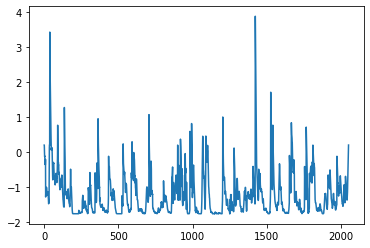

In [40]:
plt.plot(score_all)

In [41]:
(label_all==1).sum()

127

In [42]:
len(label_all)

2051

Accuracy 	0.9210
AUC score 	0.8115
FAR score 	0.6699
Precision 	0.3301
Recall   	0.2677
Macro F1 	0.6269
weighted F1 	0.9171
Avg Precision 	0.3032
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1924
           1       0.33      0.27      0.30       127

    accuracy                           0.92      2051
   macro avg       0.64      0.62      0.63      2051
weighted avg       0.91      0.92      0.92      2051



[0.9210141394441735,
 0.8114615220914434,
 0.6699029126213593,
 0.3300970873786408,
 0.2677165354330709,
 0.6269066654689184,
 0.9171379289140219,
 0.30319971490687236]

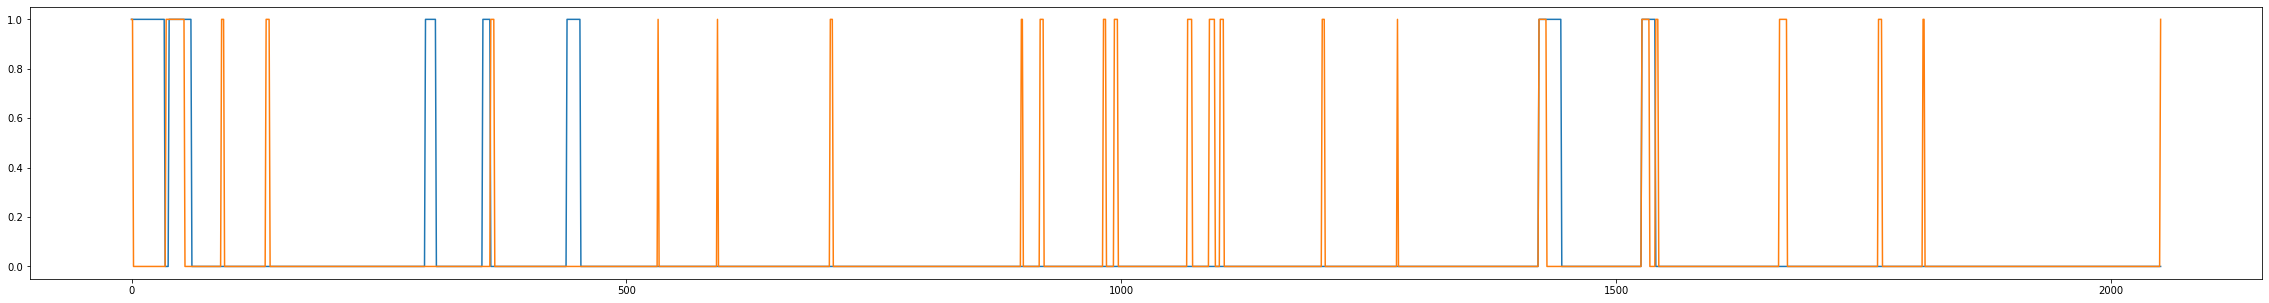

In [43]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=False, plot=True, print_=True)

In [44]:
cm = confusion_matrix(label_all, (score_all > 0).astype(int))
cm

array([[1855,   69],
       [  93,   34]])

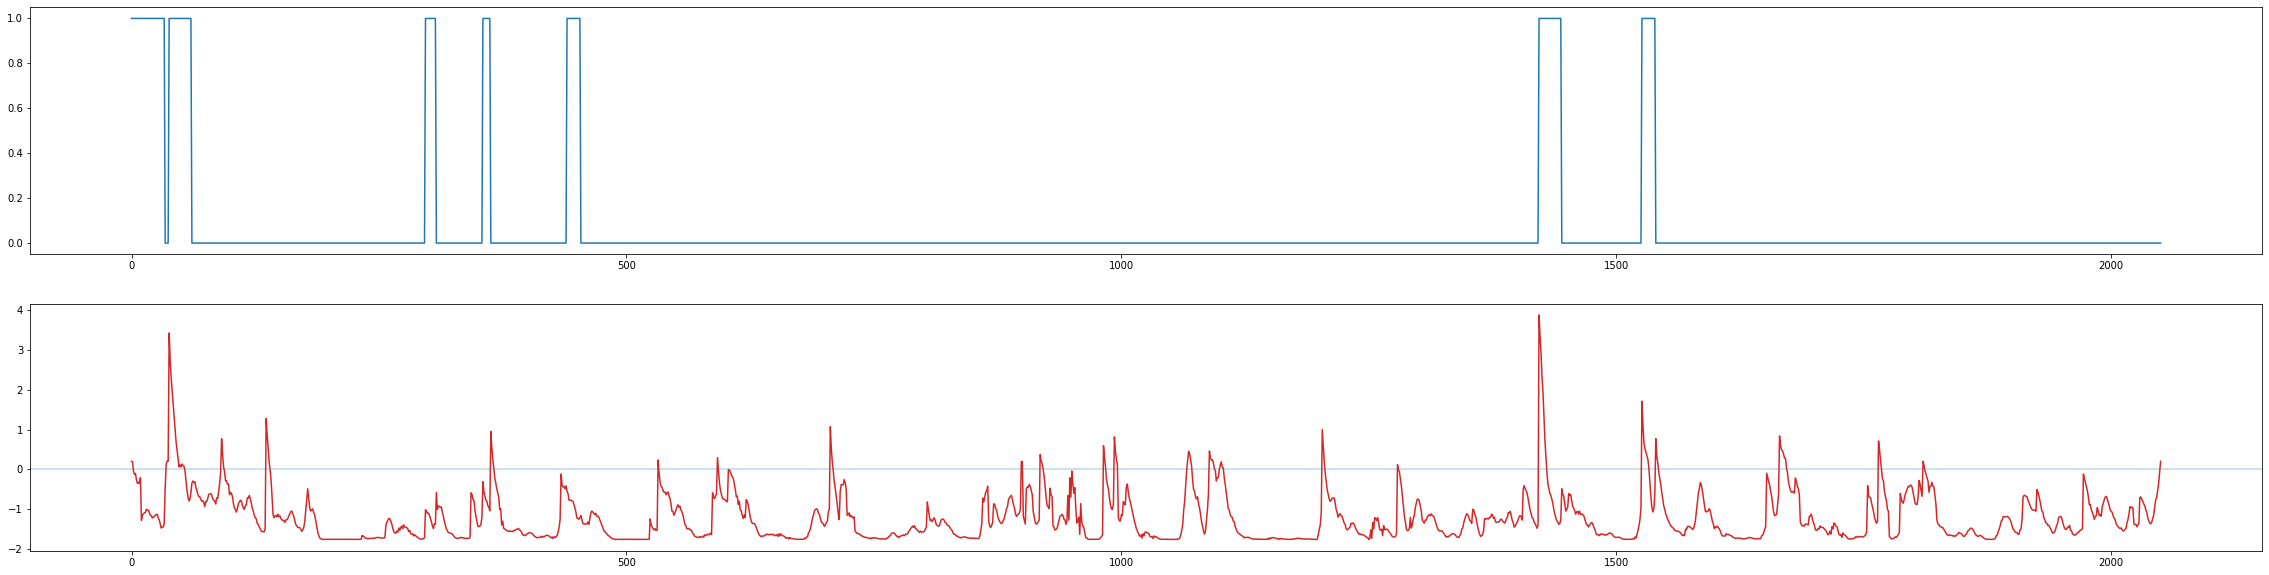

In [45]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


## Case prediction plot

In [47]:
tp = np.where((label_all == 1) & ((score_all > 0).astype(int) == 1))[0]
fp = np.where((label_all == 0) & ((score_all > 0).astype(int) == 1))[0]
tn = np.where((label_all == 0) & ((score_all > 0).astype(int) == 0))[0]
fn = np.where((label_all == 1) & ((score_all > 0).astype(int) == 0))[0]

tmp = np.random.choice(tp, 10)
tmp

array([  52,   45,   40, 1424, 1528,   47,   48, 1427,   47, 1422])

In [48]:
detected = np.where(score_all > 0)[0]
# tmp = np.argsort(score_all)[::-1]
tmp = np.random.choice(detected, 10)
tmp

array([  45,  708,   93,   43, 1093,  532,  365,  918, 1672, 1532])

In [51]:
print(target_sid)
eventID = accident_all[accident_all.accident_sid == target_sid].eventId[0]

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'

with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

hop1_up = list(np.unique([p[1] for p in path_inflow]))
hop1_down = list(np.unique([p[1] for p in path_outflow]))

test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
test_df.columns = test_df.columns.astype(int)

1210005301


In [52]:
def speed_agg(test_df):

    df_agg_inflow, df_agg_outflow = [], []
    for hop in [0, 1, 2, 3]:
        inflow = np.unique([p[hop] for p in path_inflow])
        outflow = np.unique([p[hop] for p in path_outflow])
        inflow = [p for p in inflow if p in list(test_df.columns)]
        outflow = [p for p in outflow if p in list(test_df.columns)]
        df_agg_inflow.append(test_df[inflow].mean(axis=1))
        df_agg_outflow.append(test_df[outflow].mean(axis=1))
    df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
    df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

    return df_agg_inflow, df_agg_outflow

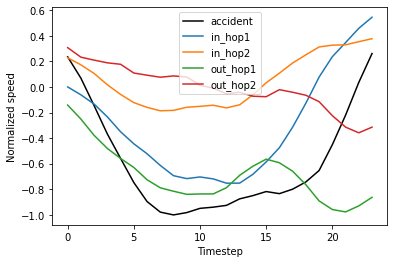

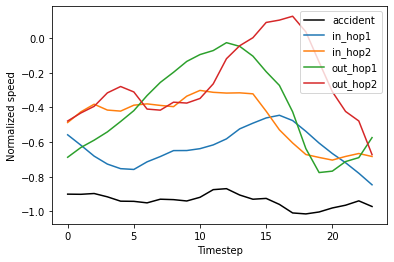

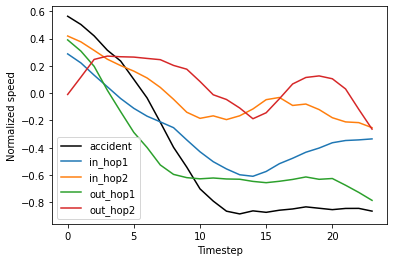

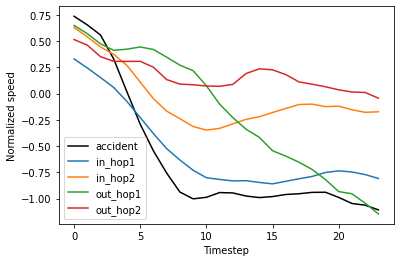

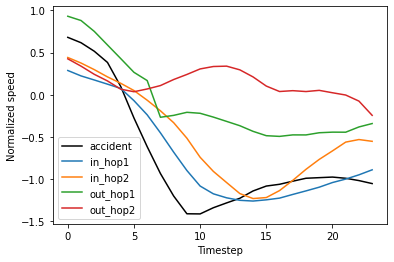

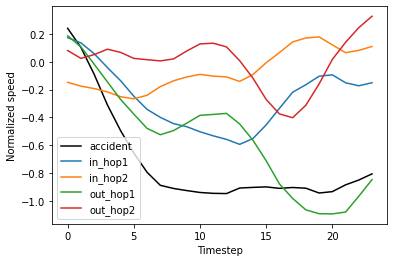

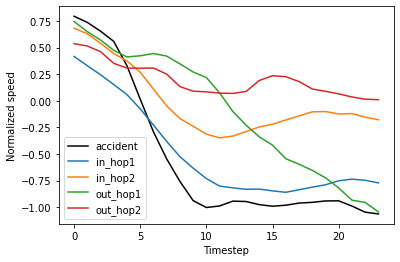

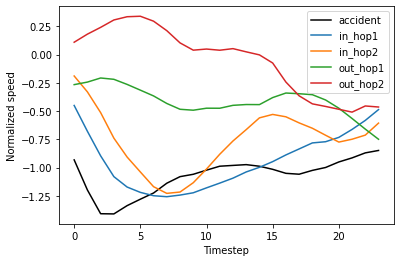

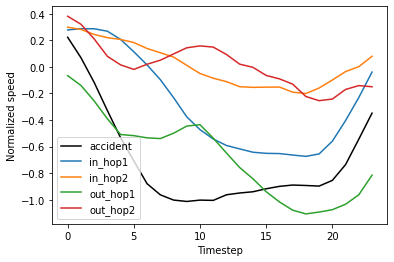

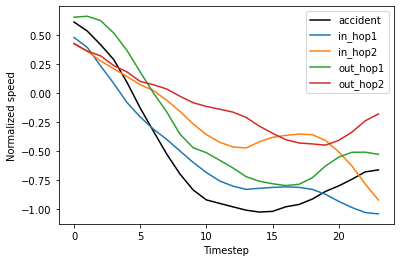

In [87]:
bs = args.batch_size
n_node = 25
for detected in tmp[:10]:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    plt.figure()
    plt.plot(df_agg_inflow[0], label='accident', color='k')
    plt.plot(df_agg_inflow[1], label='in_hop1')
    plt.plot(df_agg_inflow[2], label='in_hop2')
    plt.plot(df_agg_outflow[2], label='out_hop1')
    plt.plot(df_agg_outflow[1], label='out_hop2')
    plt.legend()
    plt.ylabel('Normalized speed')
    plt.xlabel('Timestep')
    plt.show()

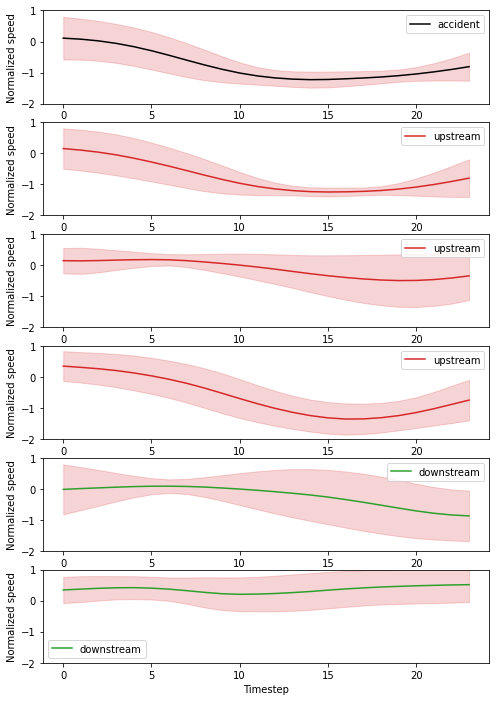

In [55]:
bs = args.batch_size
n_node = 25
pattern_all = []
# for detect_ix in detected:
for detect_ix in tp:
    i = detect_ix // args.batch_size
    j = detect_ix % args.batch_size


    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j]).T
            pattern_all.append(tmp_df)
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)
            break


pattern_mean = pd.DataFrame(np.nanmean(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_std = pd.DataFrame(np.nanstd(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_ub = pattern_mean + pattern_std
pattern_lb = pattern_mean - pattern_std

fig, ax = plt.subplots(6, 1, figsize=(8, 12))
ax[0].plot(pattern_mean[target_sid], label='accident', color='k')
ax[0].fill_between(np.arange(24), pattern_lb[target_sid], pattern_ub[target_sid], color='tab:red', alpha=0.2)

ax[1].plot(pattern_mean[hop1_up[0]], label='upstream', color='tab:red')
ax[1].fill_between(np.arange(24), pattern_lb[hop1_up[0]], pattern_ub[hop1_up[0]], color='tab:red', alpha=0.2)

ax[2].plot(pattern_mean[hop1_up[1]], label='upstream', color='tab:red')
ax[2].fill_between(np.arange(24), pattern_lb[hop1_up[1]], pattern_ub[hop1_up[1]], color='tab:red', alpha=0.2)

ax[3].plot(pattern_mean[hop1_up[3]], label='upstream', color='tab:red')
ax[3].fill_between(np.arange(24), pattern_lb[hop1_up[3]], pattern_ub[hop1_up[3]], color='tab:red', alpha=0.2)

ax[4].plot(pattern_mean[hop1_down[0]], label='downstream', color='tab:green')
ax[4].fill_between(np.arange(24), pattern_lb[hop1_down[0]], pattern_ub[hop1_down[0]], color='tab:red', alpha=0.2)

ax[5].plot(pattern_mean[hop1_down[1]], label='downstream', color='tab:green')
ax[5].fill_between(np.arange(24), pattern_lb[hop1_down[1]], pattern_ub[hop1_down[1]], color='tab:red', alpha=0.2)



for k in range(6):
    ax[k].set_ylim(-2, 1)
    ax[k].legend()
    ax[k].set_ylabel('Normalized speed')
    ax[k].set_xlabel('Timestep')
plt.show()

### Prediction Case for true incident

In [88]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

In [ ]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])

        i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop2')
        plt.legend()
        plt.show()
    

## embedding distribution plot

### Test set

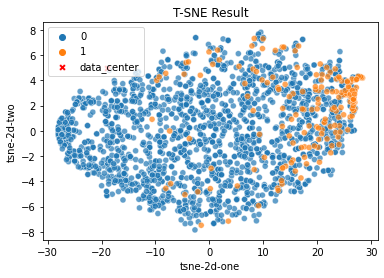

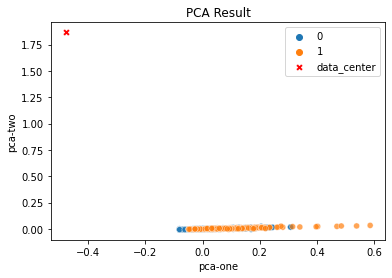

In [68]:
## test set all T-SNE
import seaborn as sns 


normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=200)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]['pca-one'], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)


plt.title('PCA Result')
plt.show()

Text(0, 0.5, 'Distance')

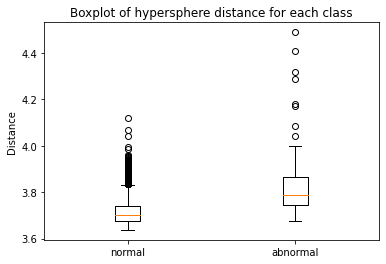

In [69]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

/tmp/ipykernel_3015882/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


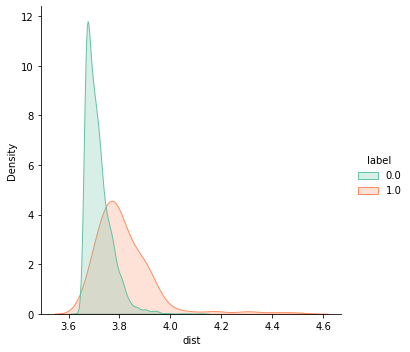

In [70]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### T-SNE comparison

train dataset


100%|██████████| 7485/7485 [00:01<00:00, 3782.20it/s]


val dataset


100%|██████████| 2269/2269 [00:00<00:00, 4280.80it/s]


test dataset


100%|██████████| 2051/2051 [00:00<00:00, 4389.01it/s]


59 18 17
Parameter number of GCN_gc Net is: 7840
./checkpoints_SAD_mprofile/1210005301_mprofile2/1210005301_mprofile2_GCN_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 118.22it/s]


[65.30883  70.225136 45.804787 47.39572  32.16981 ]


17it [00:00, 136.64it/s]


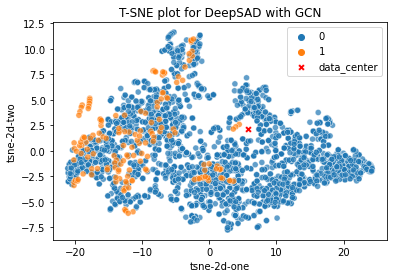

Parameter number of GAT_gc Net is: 293984
./checkpoints_SAD_mprofile/1210005301_mprofile2/1210005301_mprofile2_GAT_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 128.68it/s]


[526.1825  452.04755 184.77725 167.28099 242.9678 ]


17it [00:00, 141.63it/s]


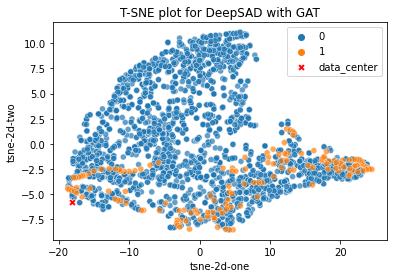

Parameter number of GraphSAGE_gc Net is: 15520
./checkpoints_SAD_mprofile/1210005301_mprofile2/1210005301_mprofile2_GraphSAGE_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 130.31it/s]


[408.8812  403.26852 298.30273 285.13113 221.1203 ]


17it [00:00, 139.53it/s]


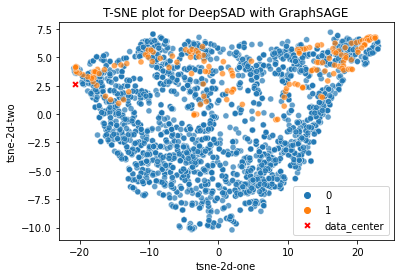

Parameter number of STGCN Net is: 4532
./checkpoints_SAD_mprofile/1210005301_mprofile2/1210005301_mprofile2_STGCN_sum_0.1_True+bestcheckpoint.pt


18it [00:00, 18.64it/s]


[1.2507765 1.2191732 1.1491442 1.123984  1.2857263]


17it [00:00, 22.69it/s]


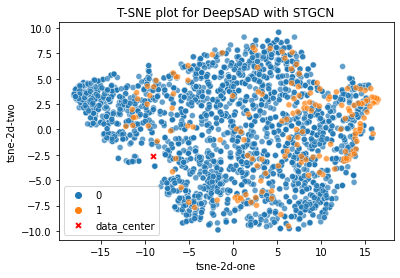

In [74]:
args.dataset = '1210005301_mprofile2'
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))


for module, name in zip(['GCN_gc', 'GAT_gc', 'GraphSAGE_gc', 'STGCN'], ['GCN','GAT', 'GraphSAGE', 'STGCN']):
# for module, name in zip(['GraphSAGE_gc'], ['GraphSAGE']):
    
    args.module = module
    name = name
    args.normalize = 'standard'
    args.nu = 0.10
    args.pooling = 'sum'
    args.reverse = False
    args.self_loop = 'True'
    args.bias = True

    args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

    checkpoints_path=f'./checkpoints_SAD_mprofile/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
    
    input_dim = 24
    model = init_model(args, input_dim)
    print(checkpoints_path)

    model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
    model.to(device=f'cuda:{args.gpu}')
    model.eval()
    data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
    radius = torch.load(checkpoints_path, map_location='cuda')['radius']


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(val_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
        # dist, score = anomaly_score(data_center, output, radius)
        dist = torch.sum((output - data_center) ** 2, dim=1)
        dist_all.append(dist.cpu().detach().numpy())
    dist_all = np.concatenate(dist_all)
    print(dist_all[:5])
    # new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
    new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
    new_radius


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(test_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
    label_all = np.concatenate(label_all)

    

    ## test set all T-SNE
    import seaborn as sns 


    normal = np.where(label_all == 0)[0]
    abnormal = np.where(label_all == 1)[0]

    rndperm = np.random.choice(normal, 3000)

    ## add data center
    center_arr = data_center.detach().cpu().numpy()
    out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

    ## tSNE
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, perplexity=200, random_state=0)
    tsne_all = tsne.fit_transform(out_center_all)

    tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
    tsne_df['y'] = np.append(label_all, [-1])

    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("tab10", 2),
        data=tsne_df.loc[np.append(rndperm, abnormal), :],
        legend="full",
        alpha=0.7
    )
    sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
        color='red',
        marker='X',
        s=50,
        label='data_center'
    )

    plt.title('T-SNE plot for DeepSAD with {}'.format(name))
    plt.show()


    

In [109]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

TypeError: only integer scalar arrays can be converted to a scalar index

# All Incidents

In [31]:
out_1 = pd.read_csv('result/1210005301_mprofile2_sumpool.csv', index_col=0)
out_2 = pd.read_csv('result/1030001902_mprofile2_sumpool.csv', index_col=0)
out_3 = pd.read_csv('result/1220005401_mprofile2_sumpool.csv', index_col=0)
out_4 = pd.read_csv('result/1210003000_mprofile2_sumpool.csv', index_col=0)
# out_5 = pd.read_csv('result/1130052300_mprofile_sumpool.csv', index_col=0)

In [72]:
out_1

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.012346,0.666667,0.333333,0.012346,0.920039,0.616965,0.491061,0.884500,0.188619
2,GAT,standard,0.01,False,0.037037,0.142857,0.857143,0.037037,0.923452,0.618019,0.515544,0.889857,0.269215
4,GraphSAGE,standard,0.01,False,0.055556,0.100000,0.900000,0.055556,0.924915,0.725814,0.532733,0.893189,0.257302
6,STGCN,standard,0.01,False,0.024691,0.000000,1.000000,0.024691,0.922964,0.724049,0.504025,0.887849,0.267980
8,GCN,standard,0.05,False,0.098765,0.589744,0.410256,0.098765,0.917601,0.495588,0.557941,0.893689,0.194595
10,GAT,standard,0.05,False,0.154321,0.778761,0.221239,0.154321,0.890297,0.663664,0.561513,0.881226,0.185384
12,GraphSAGE,standard,0.05,False,0.141975,0.540000,0.460000,0.141975,0.919064,0.681058,0.587154,0.898850,0.251239
14,STGCN,standard,0.05,False,0.148148,0.333333,0.666667,0.148148,0.926865,0.709821,0.602001,0.904775,0.315841
16,GCN,standard,0.10,False,0.129630,0.866242,0.133758,0.129630,0.864944,0.661487,0.529220,0.863975,0.121948
18,GAT,standard,0.10,False,0.185185,0.610390,0.389610,0.185185,0.912725,0.608376,0.602354,0.898166,0.255224


In [32]:
out_1 = out_1[out_1.adjust == False]
out_2 = out_2[out_2.adjust == False]
out_3 = out_3[out_3.adjust == False]
out_4 = out_4[out_4.adjust == False]
# out_5 = out_5[out_5.adjust == False]

In [33]:
tmp = np.nanmean([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:]], axis=0)  # , out_5.iloc[:,4:]
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.006333,0.866667,0.133333,0.006333,0.908096,0.526892,0.481715,0.867226,0.122769
2,GAT,standard,0.01,False,0.025433,0.524520,0.475480,0.025433,0.889198,0.531713,0.490848,0.860543,0.147449
4,GraphSAGE,standard,0.01,False,0.092193,0.631613,0.368387,0.092193,0.868655,0.574907,0.523633,0.858480,0.153830
6,STGCN,standard,0.01,False,0.017262,0.664223,0.335777,0.017262,0.904443,0.586891,0.490432,0.867402,0.162956
8,GCN,standard,0.05,False,0.033883,0.879579,0.120421,0.033883,0.873505,0.464816,0.491553,0.853448,0.107484
10,GAT,standard,0.05,False,0.064403,0.868213,0.131787,0.064403,0.880537,0.539349,0.509248,0.859705,0.121613
12,GraphSAGE,standard,0.05,False,0.099119,0.800298,0.199702,0.099119,0.854289,0.563631,0.516338,0.847350,0.148151
14,STGCN,standard,0.05,False,0.107308,0.751542,0.248458,0.107308,0.864502,0.606459,0.525826,0.855021,0.170766
16,GCN,standard,0.10,False,0.115225,0.916782,0.083218,0.115225,0.788369,0.458644,0.483889,0.806456,0.087048
18,GAT,standard,0.10,False,0.141720,0.750146,0.249854,0.141720,0.857130,0.587761,0.531364,0.850795,0.166198


In [34]:
out_all.to_csv('result/mprofile2_out_all.csv')

In [31]:
tmp = np.nanstd([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:], out_5.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.020770,0.435890,0.435890,0.020770,0.029469,0.171800,0.023073,0.030105,0.102022
2,GAT,standard,0.01,False,0.038315,0.370919,0.370919,0.038315,0.015818,0.104169,0.033070,0.021192,0.080703
4,GraphSAGE,standard,0.01,False,0.035722,0.386025,0.386025,0.035722,0.028615,0.154496,0.036325,0.028236,0.119037
6,STGCN,standard,0.01,False,0.026007,0.335648,0.335648,0.026007,0.021920,0.136423,0.025812,0.028781,0.137002
8,GCN,standard,0.05,False,0.063055,0.247957,0.247957,0.063055,0.060933,0.154225,0.061311,0.046852,0.098468
10,GAT,standard,0.05,False,0.088899,0.131186,0.131186,0.088899,0.064405,0.177712,0.051730,0.047917,0.083508
12,GraphSAGE,standard,0.05,False,0.087089,0.080940,0.080940,0.087089,0.088340,0.141454,0.045754,0.060321,0.064348
14,STGCN,standard,0.05,False,0.064498,0.337616,0.337616,0.064498,0.029931,0.160499,0.030952,0.028844,0.177834
16,GCN,standard,0.10,False,0.100271,0.098288,0.098288,0.100271,0.040522,0.120213,0.054917,0.031482,0.112822
18,GAT,standard,0.10,False,0.072452,0.163243,0.163243,0.072452,0.062634,0.087068,0.063751,0.047214,0.106457


In [32]:
out_all.to_csv('result/mprofile_out_std.csv')